___
# Introduction

Name : I Gusti Agung Istri Ratu Apsari Dewi

Batch : 02

Objectives: 

Telco Customer Churn Prediction using Artificial Neural Network (Sequential & Functional API)
___

The data set includes information about:

- Customers who left within the last month – the column is called Churn

- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

- Demographic info about customers – gender, age range, and if they have partners and dependents

# Data Loading

In [183]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np

np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import imblearn
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns

In [184]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [185]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [186]:
data.duplicated().sum()

0

In [187]:
for col in data.columns:
  print("==>", col, data[col].unique())

==> customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
==> gender ['Female' 'Male']
==> SeniorCitizen [0 1]
==> Partner ['Yes' 'No']
==> Dependents ['No' 'Yes']
==> tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
==> PhoneService ['No' 'Yes']
==> MultipleLines ['No phone service' 'No' 'Yes']
==> InternetService ['DSL' 'Fiber optic' 'No']
==> OnlineSecurity ['No' 'Yes' 'No internet service']
==> OnlineBackup ['Yes' 'No' 'No internet service']
==> DeviceProtection ['No' 'Yes' 'No internet service']
==> TechSupport ['No' 'Yes' 'No internet service']
==> StreamingTV ['No' 'Yes' 'No internet service']
==> StreamingMovies ['No' 'Yes' 'No internet service']
==> Contract ['Month-to-month' 'One year' 'Two year']
==> PaperlessBilling ['Yes' 'No']
==> PaymentMethod ['Elect

In [188]:
data[data['TotalCharges']==' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


There is missing values in Total Charges that is detected in empty object form (' '). But we found no duplicated values.

# Data Cleaning

1. Dropping row data that has no total charges amount

In [189]:
data['TotalCharges'].replace(to_replace = ' ', value= np.nan, inplace = True)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors = 'coerce')
data.dropna(axis=0, inplace=True)

2. Drop customer id column, because we don't need id to determine churn.

In [190]:
data.drop(['customerID'], axis=1, inplace=True)

# Exploratory Data Analysis

**1. Churn Customer**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


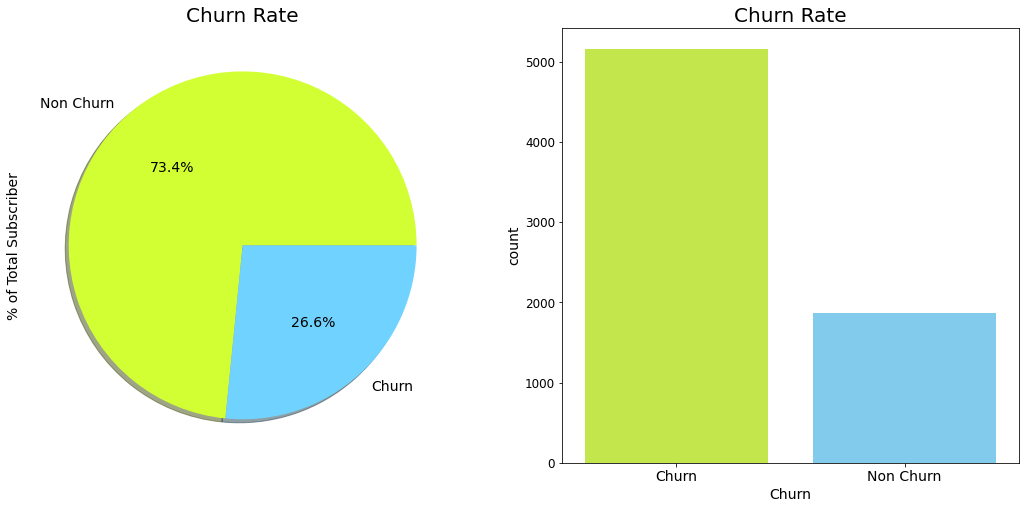

In [254]:
f, ax = plt.subplots(1,2,figsize=(18,8))
colors = ["#D1FF33","#70D2FE"]
labels = 'Non Churn','Churn'
data['Churn'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True, colors=colors, labels=labels, fontsize=14)
ax[0].set_title('Churn Rate', fontsize=20)
ax[0].set_ylabel('% of Total Subscriber', fontsize=14)

sns.countplot(data['Churn'], ax=ax[1], palette=colors)
ax[1].set_title('Churn Rate', fontsize= 20)
ax[1].set_xticklabels(['Churn','Non Churn'], fontsize=14)
plt.show()


In [192]:
len(data['Churn'])

7032

Churn rate in 26.6% from total 7,032 subscriber. The number is quite high, therefore we need to explore which customer segment is more likely to churn.

**2. Gender, Partner and Dependents impact to churn rate**

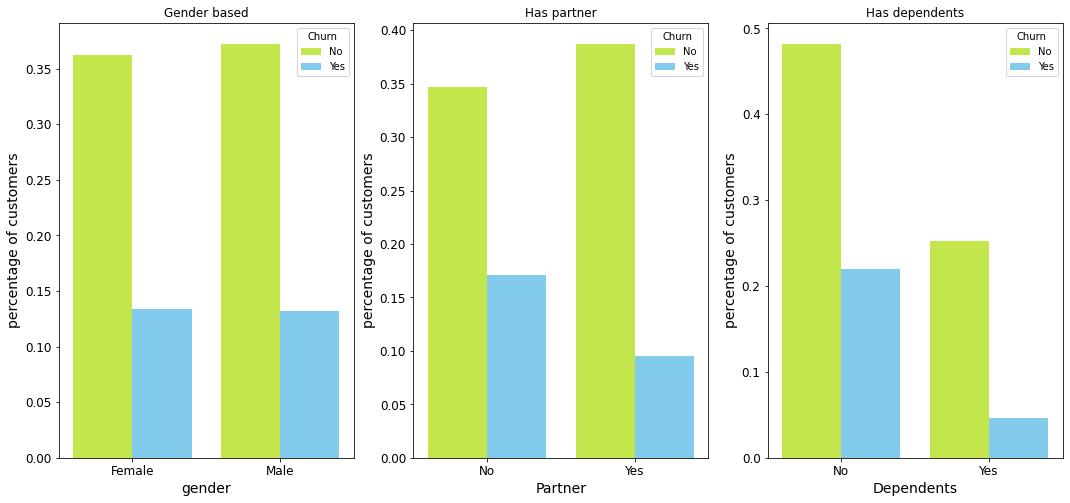

In [255]:
fig, axis = plt.subplots(1, 3, figsize=(18,8))
axis[0].set_title("Gender based")
axis[1].set_title("Has partner")
axis[2].set_title("Has dependents")
axis_y = "percentage of customers"

# Plot Gender column
datgender = data.groupby('gender')["Churn"].value_counts()/len(data)
datgender = datgender.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='gender', y= axis_y, hue='Churn', data=datgender, ax=axis[0], palette=colors)
# Plot Partner column
datpartner = data.groupby('Partner')["Churn"].value_counts()/len(data)
datpartner = datpartner.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Partner', y= axis_y, hue='Churn', data=datpartner, ax=axis[1], palette=colors)
# Plot Dependents column
datdep = data.groupby('Dependents')["Churn"].value_counts()/len(data)
datdep = datdep.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Dependents', y= axis_y, hue='Churn', data=datdep, ax=axis[2], palette=colors)

Both Female and male has similar churn rate, so gender is not related to attrition. Meanwhile customer that does not have partner or dependents has higher churn rate than the one that has partner or dependent. Now we can assume that most subscriber that share their subscription with family or partner are more likely to sustain. 

**3. Product Service signed up by Customer**

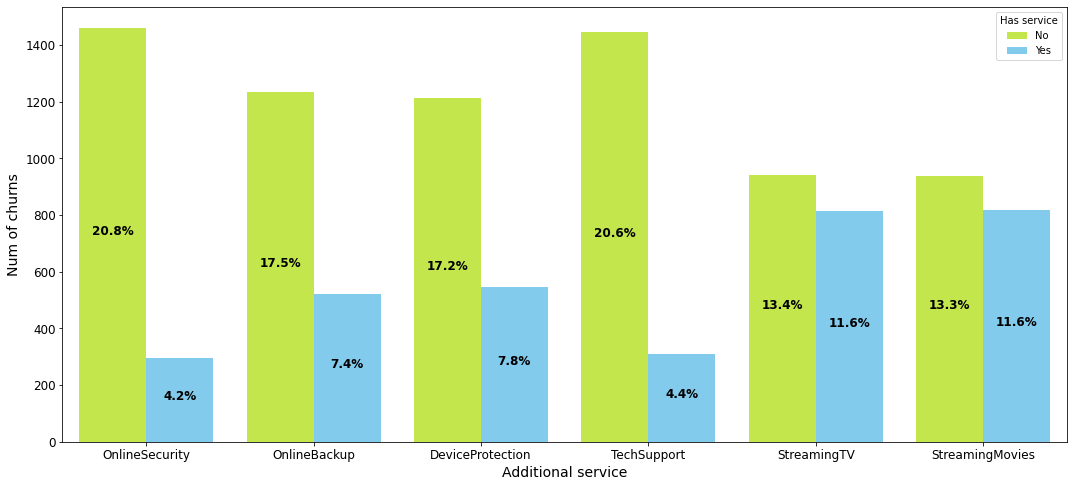

In [256]:
cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies']

plt.figure(figsize=(18, 8))
data1 = data[(data.InternetService != "No") & (data.Churn == "Yes")]
data1 = pd.melt(data1[cols]).rename({'value': 'Has service'}, axis=1)
ax = sns.countplot(data=data1, x='variable', hue='Has service', hue_order=['No', 'Yes'], palette=colors)
ax.set(xlabel='Additional service', ylabel='Num of churns')

for patch in ax.patches:
    ax.text(x = patch.get_x() + patch.get_width()/2, y = patch.get_height()/2, 
            s = f"{np.round(patch.get_height()/len(data)*100, 1)}%", 
            ha = 'center', size = 12, rotation = 0, weight = 'bold' ,color = 'black')

plt.show()

After filtering churn customer only that has internet service, we found out that: 

- Customer who signed up for online security, online backup, device protection and tech support services has low churn rate.

- Around half of customer with streaming TV, and streaming Movies service is more likely to churn. Therefore, those two services is not predictive for churn. 

**4. Contract and Payment Method**

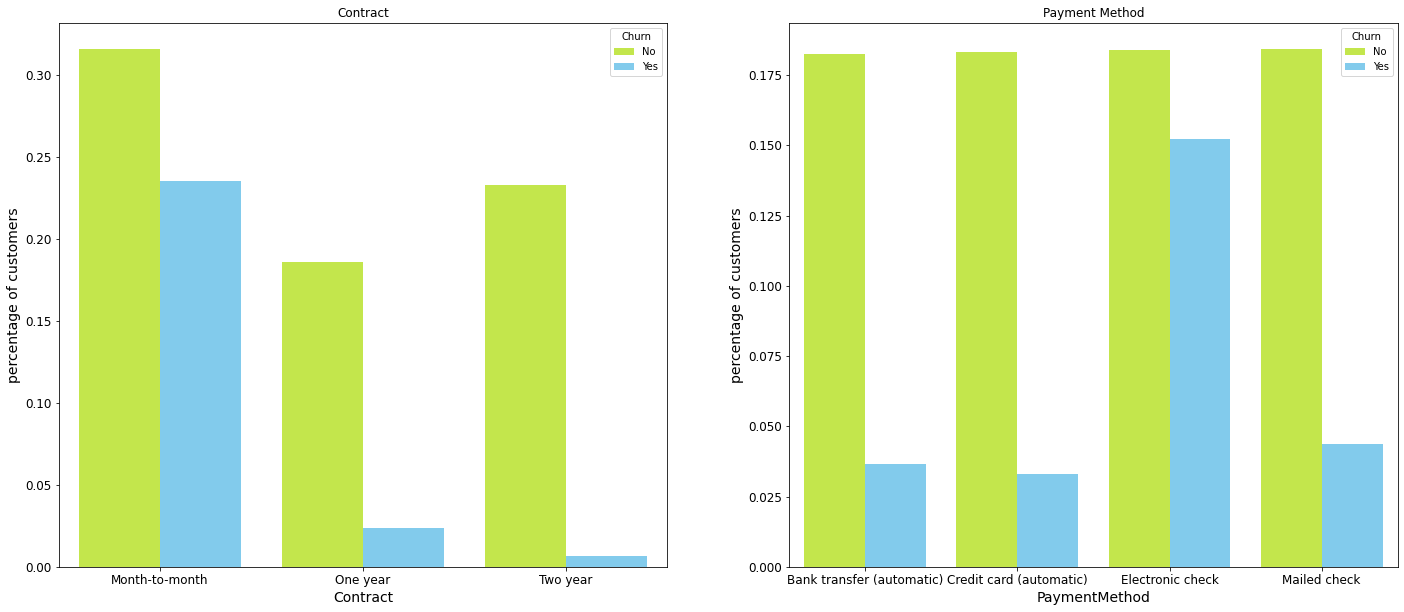

In [257]:
fig, axis = plt.subplots(1, 2, figsize=(24,10))
axis[0].set_title("Contract")
axis[1].set_title("Payment Method")
axis_y = "percentage of customers"

# Plot Contract column
datcontract = data.groupby('Contract')["Churn"].value_counts()/len(data)
datcontract = datcontract.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Contract', y= axis_y, hue='Churn', data=datcontract, ax=axis[0], palette=colors)
# Plot Monthly Charges column
datpay = data.groupby('PaymentMethod')["Churn"].value_counts()/len(data)
datpay = datpay.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='PaymentMethod', y= axis_y, hue='Churn', data=datpay, ax=axis[1], palette=colors)

- Month to month contract is more likely to churn than long term contract (1-2 year).
- Electronic check is most preferable payment method, however customer with electronic check has higher churn rate than other method.

# Data Preprocessing

1. Determine target feature into 'y' and input feature into 'X'

In [196]:
X = data.loc[:, data.columns != 'Churn']
y = data[['Churn']].copy()

2. Handling imbalanced data using SMOTE

In [197]:
ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
X_ros, y_ros = ros.fit_resample(X, y)

print('original dataset shape:', Counter(y.unstack()))
print('Resample dataset shape', Counter(y_ros))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


original dataset shape: Counter({'No': 5163, 'Yes': 1869})
Resample dataset shape Counter({'No': 5163, 'Yes': 5163})


In [198]:
X_ros = pd.DataFrame(X_ros, columns=['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'])
y_ros = pd.DataFrame(y_ros, columns=['Churn'])

3. Divide dataset 3 categories: data train (80%), data valid (10%) and data test (10%).

In [199]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_ros, y_ros, test_size= 0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size= 0.1 , random_state=42)

4. Create a transformer pipeline using sklearn

In [200]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [201]:
num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']
cat_cols = list(set(X.columns)- set(num_cols))

num_pipeline = Pipeline([
                         ('selector', OldDataFrameSelector(num_cols)),
                         ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
                         ('selector', OldDataFrameSelector(cat_cols)),
                         ('cat_encoder', OrdinalEncoder()),
                         ])

In [202]:
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

4. Transform each input feature (X) using transformer sklearn created before.

In [203]:
X_train = full_pipeline.fit_transform(X_train)
X_valid = full_pipeline.transform(X_valid)
X_test = full_pipeline.transform(X_test)

5. Transform target feature (y) into binary class Yes = 1 and No = 0

In [204]:
ordinal = OrdinalEncoder(categories=[['No','Yes']])
y_train = ordinal.fit_transform(y_train)
y_valid = ordinal.transform(y_valid)
y_test = ordinal.transform(y_test)

# Modelling

## 1. Sequential API

In [205]:
model = keras.Sequential([
      keras.layers.Dense(19, activation='relu', input_shape=(X_train.shape[-1],)),
      keras.layers.Dense(10, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

In [206]:
model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_201 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_202 (Dense)            (None, 10)                200       
_________________________________________________________________
dense_203 (Dense)            (None, 1)                 11        
Total params: 591
Trainable params: 591
Non-trainable params: 0
_________________________________________________________________


In Sequential model we are trying to create simple model connsist of:
- 1 Input layer that has 19 nodes, as all input feature will be used.
- 1 Dense layer that has 10 nodes, we are trying to decrease nodes into half
- 1 Output layer with 1 nodes, as we are expecting only 1 output

Activation function used is ReLU for input and dense layer, and output layer will have sigmoid for binary class.

In [207]:
metrics = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      ]

In [208]:
model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

In [209]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
262/262 [==============================] - 2s 4ms/step - loss: 0.5557 - accuracy: 0.7148 - precision: 0.7201 - recall: 0.7062 - auc: 0.7931 - val_loss: 0.5027 - val_accuracy: 0.7441 - val_precision: 0.7494 - val_recall: 0.7267 - val_auc: 0.8327
Epoch 2/30
262/262 [==============================] - 1s 2ms/step - loss: 0.4888 - accuracy: 0.7595 - precision: 0.7545 - recall: 0.7720 - auc: 0.8426 - val_loss: 0.4941 - val_accuracy: 0.7462 - val_precision: 0.7368 - val_recall: 0.7592 - val_auc: 0.8365
Epoch 3/30
262/262 [==============================] - 1s 2ms/step - loss: 0.4829 - accuracy: 0.7631 - precision: 0.7562 - recall: 0.7791 - auc: 0.8461 - val_loss: 0.4922 - val_accuracy: 0.7409 - val_precision: 0.7218 - val_recall: 0.7766 - val_auc: 0.8378
Epoch 4/30
262/262 [==============================] - 1s 2ms/step - loss: 0.4800 - accuracy: 0.7631 - precision: 0.7509 - recall: 0.7901 - auc: 0.8479 - val_loss: 0.4905 - val_accuracy: 0.7505 - val_precision: 0.7313 - val_recall: 0

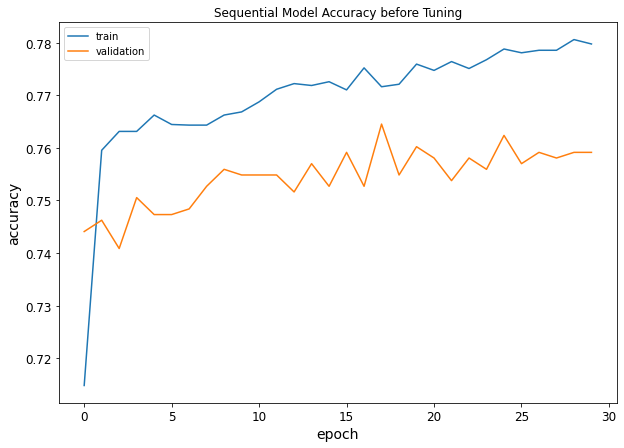

In [210]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Sequential Model Accuracy before Tuning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

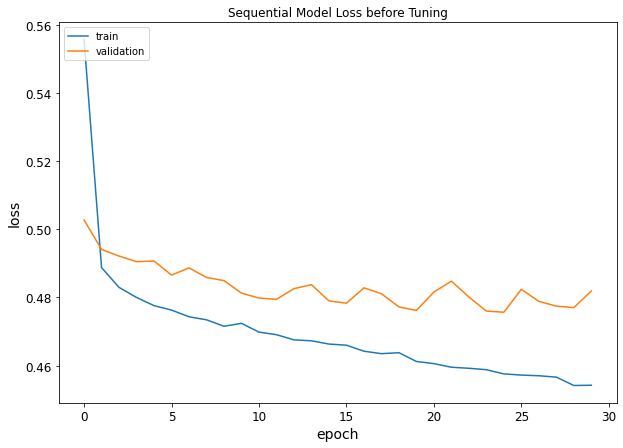

In [211]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Sequential Model Loss before Tuning')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Sequential Model Evaluation before tuning:**

1. Data train and validation show similar increase in accuracy, however in 15 to 23 epoch, data validation seems fluctuate towards its max accuracy.

2. In loss graph, data train showing gradual loss while data validation remain constant.

### Hyperparameter Tuning

In [212]:
def create_model(optimizer='adam', init='he_normal'):
  model = keras.Sequential([
      keras.layers.Dense(19, activation='relu', input_shape=(X_train.shape[-1],), kernel_initializer=init),
      keras.layers.Dense(10, activation='relu', kernel_initializer=init),
      keras.layers.Dense(1, activation='sigmoid', kernel_initializer=init),
  ])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  
  return model

In [213]:
# Create sklearn model for network
model_init_batch_epoch_CV = KerasClassifier(build_fn=create_model, verbose=1)

# Define hyperparameter
init_mode = ['he_normal', 'he_uniform']
batches = [128, 256]
epochs = [20, 30]

param_grid = dict(epochs=epochs, batch_size=batches, init=init_mode)
grid = GridSearchCV(estimator=model_init_batch_epoch_CV, param_grid=param_grid, cv=3)

grid_result=grid.fit(X_train, y_train)

Epoch 1/20
44/44 [==============================] - 1s 2ms/step - loss: 0.6516 - accuracy: 0.6467 - precision: 0.6243 - recall: 0.7181 - auc: 0.7051
Epoch 2/20
44/44 [==============================] - 0s 2ms/step - loss: 0.5499 - accuracy: 0.7340 - precision: 0.7424 - recall: 0.7077 - auc: 0.7973
Epoch 3/20
44/44 [==============================] - 0s 2ms/step - loss: 0.5160 - accuracy: 0.7453 - precision: 0.7505 - recall: 0.7265 - auc: 0.8253
Epoch 4/20
44/44 [==============================] - 0s 2ms/step - loss: 0.5042 - accuracy: 0.7503 - precision: 0.7506 - recall: 0.7414 - auc: 0.8328
Epoch 5/20
44/44 [==============================] - 0s 2ms/step - loss: 0.4964 - accuracy: 0.7548 - precision: 0.7527 - recall: 0.7508 - auc: 0.8372
Epoch 6/20
44/44 [==============================] - 0s 2ms/step - loss: 0.4910 - accuracy: 0.7548 - precision: 0.7487 - recall: 0.7588 - auc: 0.8402
Epoch 7/20
44/44 [==============================] - 0s 2ms/step - loss: 0.4873 - accuracy: 0.7587 - precis

In [214]:
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.7698 using {'batch_size': 256, 'epochs': 20, 'init': 'he_normal'}
mean=0.7638, std=0.01146 using {'batch_size': 128, 'epochs': 20, 'init': 'he_normal'}
mean=0.7661, std=0.002389 using {'batch_size': 128, 'epochs': 20, 'init': 'he_uniform'}
mean=0.7662, std=0.00848 using {'batch_size': 128, 'epochs': 30, 'init': 'he_normal'}
mean=0.7693, std=0.008399 using {'batch_size': 128, 'epochs': 30, 'init': 'he_uniform'}
mean=0.7698, std=0.005746 using {'batch_size': 256, 'epochs': 20, 'init': 'he_normal'}
mean=0.7605, std=0.004255 using {'batch_size': 256, 'epochs': 20, 'init': 'he_uniform'}
mean=0.7644, std=0.007848 using {'batch_size': 256, 'epochs': 30, 'init': 'he_normal'}
mean=0.7634, std=0.006832 using {'batch_size': 256, 'epochs': 30, 'init': 'he_uniform'}


Best parameter for sequential model above: 
- Batch size : 256
- Epochs : 30
- Kernel initializer : he_normal

After getting the best parameter, then we apply to the final sequential model below and start training again. 

In [215]:
model_seq2 = keras.Sequential([
      keras.layers.Dense(19, activation='relu', input_shape=(X_train.shape[-1],), kernel_initializer='he_normal'),
      keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),
      keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal'),
  ])

model_seq2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

In [216]:
model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_201 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_202 (Dense)            (None, 10)                200       
_________________________________________________________________
dense_203 (Dense)            (None, 1)                 11        
Total params: 591
Trainable params: 591
Non-trainable params: 0
_________________________________________________________________


In [217]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mcp_seq_save = keras.callbacks.ModelCheckpoint('my_seq_model.h5', save_best_only=True, monitor='val_loss')

history1 = model_seq2.fit(X_train, y_train, epochs=30, batch_size=256, callbacks=[early_stopping, mcp_seq_save], validation_data=(X_valid, y_valid))
model = keras.models.load_model("my_seq_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/30
33/33 [==============================] - 2s 19ms/step - loss: 0.6872 - accuracy: 0.6805 - precision: 0.7152 - recall: 0.6038 - auc: 0.7559 - val_loss: 0.6672 - val_accuracy: 0.6323 - val_precision: 0.6427 - val_recall: 0.5813 - val_auc: 0.6644
Epoch 2/30
33/33 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6736 - precision: 0.6718 - recall: 0.6833 - auc: 0.7264 - val_loss: 0.6382 - val_accuracy: 0.6849 - val_precision: 0.6615 - val_recall: 0.7462 - val_auc: 0.7227
Epoch 3/30
33/33 [==============================] - 0s 4ms/step - loss: 0.6061 - accuracy: 0.7058 - precision: 0.6847 - recall: 0.7670 - auc: 0.7703 - val_loss: 0.5962 - val_accuracy: 0.7000 - val_precision: 0.6723 - val_recall: 0.7701 - val_auc: 0.7639
Epoch 4/30
33/33 [==============================] - 0s 3ms/step - loss: 0.5539 - accuracy: 0.7307 - precision: 0.7096 - recall: 0.7844 - auc: 0.8045 - val_loss: 0.5486 - val_accuracy: 0.7237 - val_precision: 0.6977 - val_recall: 0.7809 -

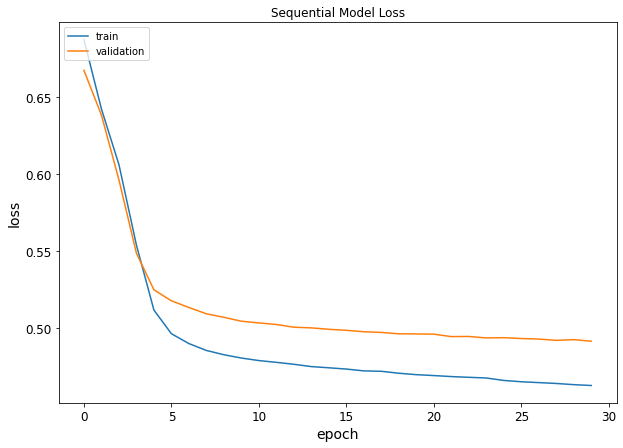

In [218]:
plt.figure(figsize=(10, 7))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Sequential Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

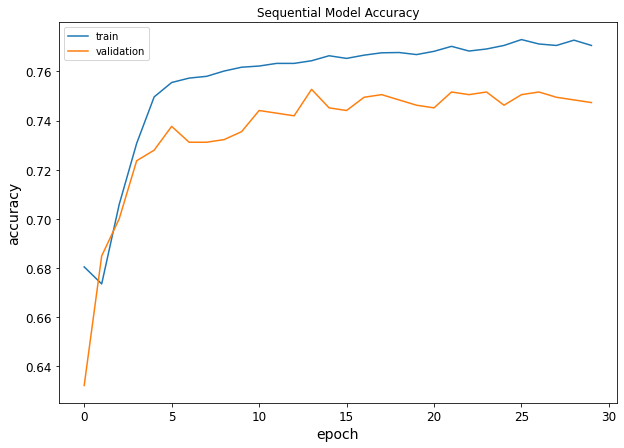

In [219]:
plt.figure(figsize=(10, 7))
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Sequential Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Sequential Model Evaluation after tuning:**

1. Both loss and accuracy graph remain constant during training.

2. Data accuracy slightly increasing after tuning from 79% to 80%, also AUC Score increasing from 0.875 to 0.886.

3. Test result using simple sequential API:

|Metrics|Score|
|---|---|
|loss|0.4967|
|accuracy|0.7657|
|precision|0.7563|
|recall|0.7683|
|AUC|0.8449|

## 2. Functional API

In [220]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(15, activation="relu")(input_)
concat = keras.layers.concatenate([input_, hidden1])
hidden2 = keras.layers.Dense(20, activation="relu")(concat)
output = keras.layers.Dense(1, activation='sigmoid')(hidden2)
model2 = keras.models.Model(inputs=[input_], outputs=[output])

In [221]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 19)]         0                                            
__________________________________________________________________________________________________
dense_282 (Dense)               (None, 15)           300         input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 34)           0           input_3[0][0]                    
                                                                 dense_282[0][0]                  
__________________________________________________________________________________________________
dense_283 (Dense)               (None, 20)           700         concatenate_2[0][0]        

Functional model consist of:
- 1 Input layer that has 19 nodes, as all input feature will be used.
- 2 Dense layer that has 15 nodes and 20 for the second dense layer
- Concatenate in attempt to apply skip connection technique, merging input and 1st dense layer.
- 1 Output layer with 1 nodes, as we are expecting only 1 output

Activation function used is ReLU for input and dense layer, and output layer will have sigmoid for binary class.

In [222]:
model2.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

In [223]:
history2 = model2.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
262/262 [==============================] - 2s 4ms/step - loss: 0.5457 - accuracy: 0.7180 - precision: 0.7275 - recall: 0.6992 - auc: 0.7998 - val_loss: 0.5014 - val_accuracy: 0.7452 - val_precision: 0.7121 - val_recall: 0.8156 - val_auc: 0.8293
Epoch 2/20
262/262 [==============================] - 1s 2ms/step - loss: 0.4825 - accuracy: 0.7631 - precision: 0.7411 - recall: 0.8115 - auc: 0.8460 - val_loss: 0.4945 - val_accuracy: 0.7527 - val_precision: 0.7421 - val_recall: 0.7679 - val_auc: 0.8341
Epoch 3/20
262/262 [==============================] - 1s 2ms/step - loss: 0.4772 - accuracy: 0.7646 - precision: 0.7470 - recall: 0.8027 - auc: 0.8497 - val_loss: 0.4919 - val_accuracy: 0.7473 - val_precision: 0.7260 - val_recall: 0.7874 - val_auc: 0.8360
Epoch 4/20
262/262 [==============================] - 1s 2ms/step - loss: 0.4740 - accuracy: 0.7683 - precision: 0.7509 - recall: 0.8053 - auc: 0.8520 - val_loss: 0.4900 - val_accuracy: 0.7516 - val_precision: 0.7246 - val_recall: 0

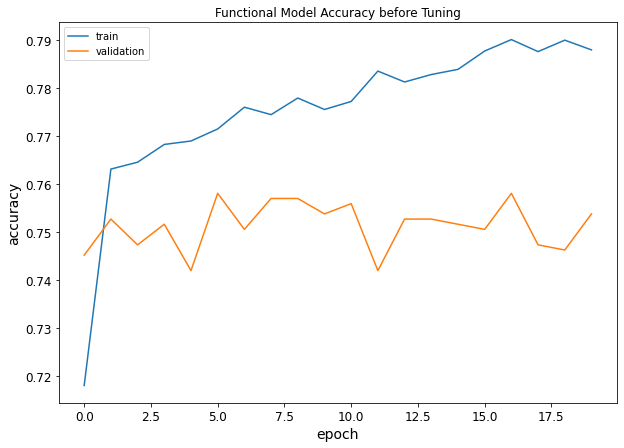

In [225]:
plt.figure(figsize=(10, 7))
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Functional Model Accuracy before Tuning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

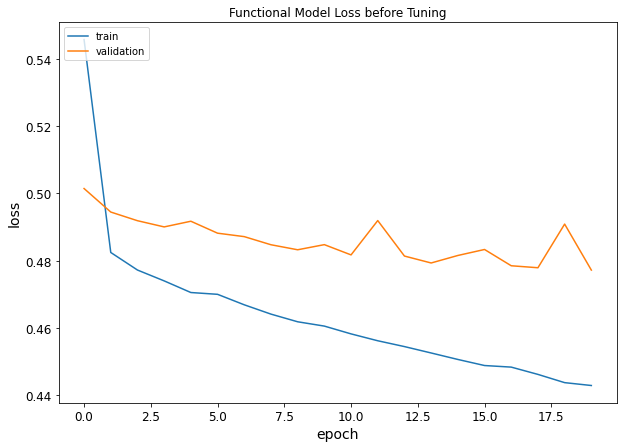

In [226]:
plt.figure(figsize=(10, 7))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Functional Model Loss before Tuning')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Functional Model Evaluation before tuning:**

1. Data train showing gradual increase in accuracy, however data validation remain slightly decreasing which is not good.

2. In loss graph, data train showing gradual loss while data validation remain constant.

### Hyperparameter Tuning

In [227]:
def create_model2(optimizer='adam'):
  input_ = keras.layers.Input(shape=X_train.shape[1:],)
  hidden1 = keras.layers.Dense(15, activation="relu")(input_)
  concat = keras.layers.concatenate([input_, hidden1])
  hidden2 = keras.layers.Dense(20, activation="relu")(concat)
  output = keras.layers.Dense(1, activation='sigmoid')(hidden2)
  model = keras.models.Model(inputs=[input_], outputs=[output])
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  
  return model

In [228]:
# Create sklearn model for network
model_func_batch_epoch_CV = KerasClassifier(build_fn=create_model, verbose=1)

# Define hyperparameter
batches = [32, 64, 128, 256]
epochs = [20, 30, 50]

param_grid = dict(epochs=epochs, batch_size=batches)
grid = GridSearchCV(estimator=model_func_batch_epoch_CV, param_grid=param_grid, cv=3)

grid_result=grid.fit(X_train, y_train)

Epoch 1/20
175/175 [==============================] - 1s 2ms/step - loss: 0.5719 - accuracy: 0.7042 - precision: 0.7127 - recall: 0.6737 - auc: 0.7821
Epoch 2/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4977 - accuracy: 0.7566 - precision: 0.7396 - recall: 0.7838 - auc: 0.8331
Epoch 3/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4863 - accuracy: 0.7613 - precision: 0.7422 - recall: 0.7925 - auc: 0.8417
Epoch 4/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4813 - accuracy: 0.7636 - precision: 0.7410 - recall: 0.8023 - auc: 0.8456
Epoch 5/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4789 - accuracy: 0.7659 - precision: 0.7454 - recall: 0.7998 - auc: 0.8475
Epoch 6/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4760 - accuracy: 0.7632 - precision: 0.7436 - recall: 0.7954 - auc: 0.8496
Epoch 7/20
175/175 [==============================] - 0s 2ms/step - loss: 0.4736 - accuracy: 0

In [229]:
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.782 using {'batch_size': 32, 'epochs': 50}
mean=0.7699, std=0.003954 using {'batch_size': 32, 'epochs': 20}
mean=0.7728, std=0.004563 using {'batch_size': 32, 'epochs': 30}
mean=0.782, std=0.008764 using {'batch_size': 32, 'epochs': 50}
mean=0.7698, std=0.005697 using {'batch_size': 64, 'epochs': 20}
mean=0.7711, std=0.005591 using {'batch_size': 64, 'epochs': 30}
mean=0.7746, std=0.006134 using {'batch_size': 64, 'epochs': 50}
mean=0.7672, std=0.005767 using {'batch_size': 128, 'epochs': 20}
mean=0.7668, std=0.004841 using {'batch_size': 128, 'epochs': 30}
mean=0.7714, std=0.005223 using {'batch_size': 128, 'epochs': 50}
mean=0.7626, std=0.001597 using {'batch_size': 256, 'epochs': 20}
mean=0.7647, std=0.002557 using {'batch_size': 256, 'epochs': 30}
mean=0.7667, std=0.004295 using {'batch_size': 256, 'epochs': 50}


Best parameter for functional model above: 
- Batch size : 32
- Epochs : 20

After getting the best parameter, then we apply to the final functional model below and start training again. 

In [230]:
input_ = keras.layers.Input(shape=X_train.shape[1:],)
hidden1 = keras.layers.Dense(15, activation="relu")(input_)
concat = keras.layers.concatenate([input_, hidden1])
hidden2 = keras.layers.Dense(20, activation="relu")(concat)
output = keras.layers.Dense(1, activation='sigmoid')(hidden2)
model_func2 = keras.models.Model(inputs=[input_], outputs=[output])

In [231]:
model_func2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 19)]         0                                            
__________________________________________________________________________________________________
dense_396 (Dense)               (None, 15)           300         input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 34)           0           input_4[0][0]                    
                                                                 dense_396[0][0]                  
__________________________________________________________________________________________________
dense_397 (Dense)               (None, 20)           700         concatenate_3[0][0]        

In [232]:
model_func2.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

In [233]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mcp_func_save = keras.callbacks.ModelCheckpoint('my_func_model.h5', save_best_only=True, monitor='val_loss')

history3 = model_func2.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping,mcp_func_save], validation_data=(X_valid, y_valid))
model = keras.models.load_model("my_func_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
262/262 [==============================] - 2s 4ms/step - loss: 0.5266 - accuracy: 0.7688 - precision: 0.7514 - recall: 0.8059 - auc: 0.8526 - val_loss: 0.5054 - val_accuracy: 0.7398 - val_precision: 0.7143 - val_recall: 0.7918 - val_auc: 0.8300
Epoch 2/100
262/262 [==============================] - 1s 2ms/step - loss: 0.4825 - accuracy: 0.7661 - precision: 0.7525 - recall: 0.7956 - auc: 0.8465 - val_loss: 0.4963 - val_accuracy: 0.7419 - val_precision: 0.7223 - val_recall: 0.7787 - val_auc: 0.8361
Epoch 3/100
262/262 [==============================] - 1s 2ms/step - loss: 0.4758 - accuracy: 0.7690 - precision: 0.7566 - recall: 0.7956 - auc: 0.8512 - val_loss: 0.4946 - val_accuracy: 0.7462 - val_precision: 0.7168 - val_recall: 0.8069 - val_auc: 0.8376
Epoch 4/100
262/262 [==============================] - 1s 2ms/step - loss: 0.4719 - accuracy: 0.7690 - precision: 0.7542 - recall: 0.8006 - auc: 0.8538 - val_loss: 0.4936 - val_accuracy: 0.7409 - val_precision: 0.7124 - val_recal

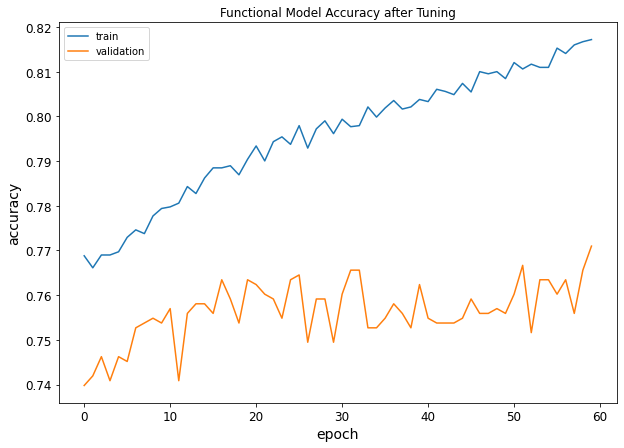

In [234]:
plt.figure(figsize=(10, 7))
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Functional Model Accuracy after Tuning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

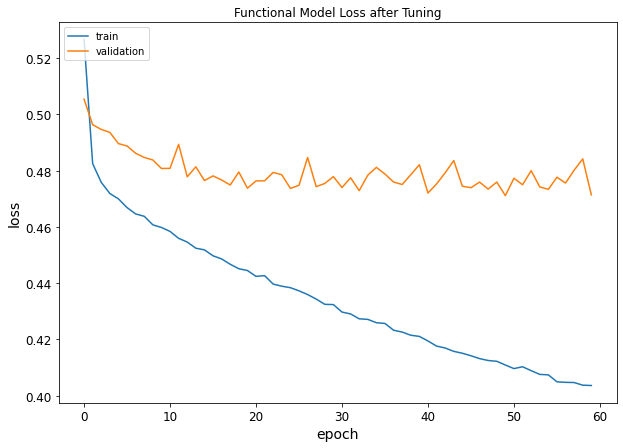

In [235]:
plt.figure(figsize=(10, 7))
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Functional Model Loss after Tuning')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Functional Model Evaluation after tuning:**

1. Both loss and accuracy graph remain constant during training, except for data validation in accuracy score showing slight increase.

2. Data accuracy slightly increasing after tuning from 80% to 94.5%, also AUC Score increasing from 0.893 to 0.9215.

3. Test result using simple functional API:

|Metrics|Score|
|---|---|
|loss|0.4999|
|accuracy|0.7977|
|precision|0.7782|
|recall|0.8198|
|AUC|0.8682|

# Model Inference

In [245]:
new_data = data.sample(3)
new_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3855,Male,0,Yes,Yes,53,Yes,No,DSL,No,Yes,No,Yes,Yes,No,Month-to-month,No,Credit card (automatic),65.00,3363.8,No
5225,Male,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),104.45,7459.0,No
1412,Female,0,Yes,No,15,Yes,No,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,84.30,1308.4,Yes


In [246]:
new_data.drop(['Churn'], axis=1, inplace=True)

In [247]:
new_data_scaled = full_pipeline.transform(new_data)

In [248]:
model = keras.models.load_model("my_func_model.h5")
y_pred = model.predict(new_data_scaled)
prediction = np.round(y_pred, 0)
prediction

array([[0.],
       [1.],
       [1.]], dtype=float32)

In this section we are trying to predict customer class whether they belong to churn customer or not. We have 3 random samples taken from original data.
In original data, customer1 classify as churn while the other is not.
Our prediction result still have false positive in predicting client 2 when it should be not churn.

# Conclusion

**EDA Analysis**

1. Churn rate in 26.6% from total 7,032 subscriber. The number is quite high, therefore we need to explore which customer segment is more likely to churn.

2. Both Female and male has similar churn rate, so gender is not related to the churn rate. Meanwhile customer that does not have partner or dependents has higher churn rate than the one that has partner or dependent. Now we can assume that most subscriber that has family or partner are tend to keep subscribing.  

3. After filtering churn customer only that has internet service, we found out that: 

- Customer who signed up for online security, online backup, device protection and tech support services has low churn rate.

- Around half of customer with streaming TV, and streaming Movies service is more likely to churn. Therefore, those two services is not predictive for churn. 

4. Most favorable payment method and also has highest churn is coming from customer with electronic billing method. Telco could use the opportunity to improve electronic billing payment experience and hopefully retain customer from unsubscribing.

**Model Analysis**
1. In Sequential API, we use simple model with one input, one dense layer and one output. After optimizing the model using GridSearchCV help, we found best parameter:

- Batch size = 256
- Epochs = 30
- Kernel initializer = he_normal

> Model optimization showing improved in metrics:

|Data Training Metrics|Before|After|
|---|---|---|
|loss|0.4385|0.4185
|accuracy|0.7967|0.8022
|precision|0.7804|0.7834
|recall|0.8280|0.8375
|AUC|0.8750|0.8860

2. In Functional API, we are trying to apply skip connection architecture to test whether the techniques works better than using simple model. After optimizing the model using GridSearchCV help, we found best parameter:

- Batch size = 32
- Epochs = 20

> Model optimization showing improved in metrics:

|Data Training Metrics|Before|After|
|---|---|---|
|loss|0.4057|0.3502
|accuracy|0.8172|0.8456
|precision|0.7949|0.8268
|recall|0.8568|0.8759
|AUC|0.8938|0.9215

3. Test result comparation:

|Metrics|Sequential|Functional|
|---|---|---|
|loss|0.4967|0.4999|
|accuracy|0.7657|0.7977|
|precision|0.7563|0.7782|
|recall|0.7683|0.8198|
|AUC|0.8449|0.8682|

> Functional API with skip connection technique in this case proven to have better performance than sequential simple model even after optimizing each model. However we still have room for improvement, as in model inference the prediction result showing false positive churn.